# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

**Tecnológico de Monterrey**

Prof Luis Eduardo Falcón Morales

### **Actividad: Problema de Clasificación con Datos Desbalanceados**

* #### **Nombre:** _[Añade tu nombre aquí]_
* #### **Matrícula:** _[Añade tu matrícula aquí]_

# **Introducción**

* La actividad se basa en los datos conocidos como "oil-spill" (derrame de petróleo).

* En la web puedes encontrar otros archivos del mismo problema pero con diversos cambios, por lo que el archivo con el que trabajarás está en Canvas y así poder asegurar que todos están trabajando con los mismos datos. Aún en una misma página, con el tiempo se actualiza y los datos inclusive pueden ya no estar accesibles.

* El archivo de los datos con el que trabajarás está en Canvas con el nombre "oil-spill.csv".

En la siguiente liga se encuentra el artículo original relacionado a dicha base de datos. Los datos incluyen 50 columnas y 937 registros. Las primeras 49 columnas son métricas obtenidas de imágenes satelitales del océano, en algunas de las cuales se tiene petróleo que fue derramado por alguna fuente desconocida. En el artículo se describe a detalle la manera en que se obtuvieron dichas columnas. Para la actividad es suficiente considerarlas como de valor numérico, donde cada valor es una medida de información en la imagen. La última columna llamada "target" es de valor 1 (hay derrame en ese pedazo de la imagen) o 0 (no hay derrame en ese pedazo de la imagen).

https://webdocs.cs.ualberta.ca/~holte/Publications/oilspill.pdf

Por el momento es suficiente con que consideres que cada una de las 49 columnas te da información de la imagen que te ayuda a entenderla mejor. En un curso posterior de visión computacional podrás ahondar sobre cómo extraer información numérica de una imagen.

En la siguiente liga puedes encontrar información de varias de las métricas de scikit-learn que estaremos utilizando:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

La librería de scikit-learn no incluye la media geométrica **G_mean**, pero sabemos que se puede obtener con la fórmula $G_{mean}=\sqrt{\frac{VP*VN}{(VP+FN) * (VN+FP)}}$, usando los verdaderos y falsos, positivos y negativos.

Sin embargo, para fines de esta actividad usaremos la librería llamada "imbalanced-learn" que incluye dicha métrica, además de un reporte más extenso de otras métricas útiles para estos casos de datos desbalanceados:

https://glemaitre.github.io/imbalanced-learn/generated/imblearn.metrics.geometric_mean_score.html

# **Ejercicio-1**

### **En esta actividad usaremos la media geométrica G_mean como métrica principal para buscar el mejor modelo. Explica a continuación cuándo se recomienda utilizar **G_mean** en un problema de aprendizaje supervisado (a) y su diferencia o diferencias con **f1_score** (b):**

* **a)** La métrica $G_{mean}$ se recomienda cuando el conjunto de datos está fuertemente desbalanceado y nos interesa que el modelo mantenga, al mismo tiempo, una sensibilidad alta sobre la clase minoritaria y una especificidad alta sobre la clase mayoritaria. Al promediar geométricamente la tasa de verdaderos positivos y la tasa de verdaderos negativos, penaliza cualquier caída pronunciada en alguno de los extremos, por lo que evita modelos que sólo predicen la clase mayoritaria para obtener una aparente buena exactitud.

* **b)** El $f1\_score$ es la media armónica entre precisión y recall de la clase positiva. Domina los errores cometidos dentro de la clase minoritaria y no considera explícitamente qué sucede con la clase negativa. Por ello, un modelo puede tener un $f1\_score$ elevado aun cuando la especificidad sea baja. En cambio, el $G_{mean}$ combina recall y especificidad, de modo que refleja de forma simétrica el desempeño en ambas clases.

In [1]:
# Incluye todas las librerías que consideres adecuadas:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from statistics import mean, stdev

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, make_scorer, precision_recall_curve,
                                 roc_curve, auc)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     cross_val_score, cross_validate, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler

from imblearn.metrics import (classification_report_imbalanced, geometric_mean_score)

np.random.seed(42)

plt.style.use('seaborn-v0_8')

Para fines de la actividad pre-procesaremos los datos de manera estándar para concentrarnos en los temas relacionados al curso.

In [2]:
# Cargamos los datos del arcivo:
path ='oil_spill.csv'
df = pd.read_csv(path)

# Eliminamos las siguientes columnas:
df.drop("f_1", axis=1, inplace=True)    # Esta columna contiene información de secciones (batches) de las imágenes que no requerimos para esta actividad.
df.drop("f_23", axis=1, inplace=True)   # Esta columna tiene un solo valor constante.

print('Dimensión del DataFrame',df.shape)
df.head(3)


Dimensión del DataFrame (937, 48)


,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,target
0,2558,1506.09,456.63,90,6395000.0,40.88,7.89,29780.0,0.19,214.7,...,2850.0,1000.0,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,22325,79.11,841.03,180,55812500.0,51.11,1.21,61900.0,0.02,901.7,...,5750.0,11500.0,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,115,1449.85,608.43,88,287500.0,40.42,7.34,3340.0,0.18,86.1,...,1400.0,250.0,150.00,45.13,9.33,1,31692.84,65.81,7.84,1


In [3]:
# Particionamos en los datos de entrada (X) y de salida (y):
X,y = df.iloc[:,:-1], df.iloc[:,-1]

# Utilizamos las semillas indicadas para la reproducibilidad de los resultados:
Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=1)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=7)


# Veamos la partición de los tres conjuntos para que observes la poca cantidad de datos que se tienen en la clase minoritaria:
print('\nPartición:')
tmp = 100 * (ytrain.sum() / len(ytrain))
print('Train: Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f%%, Porcentaje_clase_negativa=%.2f%%' % (ytrain.sum(), tmp, 100-tmp))
tmp = 100 * (yval.sum() / len(yval))
print('Val: Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f%%, Porcentaje_clase_negativa=%.2f%%' % (yval.sum(), tmp, 100-tmp))
tmp = 100 * (ytest.sum() / len(ytest))
print('Test: Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f, Porcentaje_clase_negativa=%.2f%%%%' % (ytest.sum(), tmp, 100-tmp))


Partición:
Train: Conteo_clase_positiva=28, Porcentaje_clase_positiva=4.25%, Porcentaje_clase_negativa=95.75%
Val: Conteo_clase_positiva=8, Porcentaje_clase_positiva=4.85%, Porcentaje_clase_negativa=95.15%
Test: Conteo_clase_positiva=5, Porcentaje_clase_positiva=4.42, Porcentaje_clase_negativa=95.58%%


#### **Breve descripción numérica y gráfica del conjunto de entrenamiento:**

In [4]:
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
f_2,659.0,350.377845,1.911459e+03,10.00,19.000,63.00,134.000,28526.00
f_3,659.0,692.040516,6.013521e+02,1.92,83.905,646.26,1229.325,1789.13
f_4,659.0,853.822398,5.259526e+02,1.00,435.500,719.81,1238.040,2724.57
f_5,659.0,85.613050,4.564260e+01,0.00,54.000,74.00,120.500,180.00
f_6,659.0,831366.966616,4.158159e+06,71718.00,125000.000,185000.00,337500.000,71315000.00
f_7,659.0,43.517132,1.287405e+01,21.24,33.760,40.35,53.090,82.64
f_8,659.0,9.244294,3.590490e+00,1.21,6.935,8.33,11.045,23.47
f_9,659.0,4094.624431,8.960913e+03,704.00,1332.000,2100.00,3445.000,160740.00
f_10,659.0,0.221730,8.687786e-02,0.02,0.170,0.21,0.260,0.67
f_11,659.0,110.794537,6.187135e+01,41.00,84.400,100.10,116.300,901.70


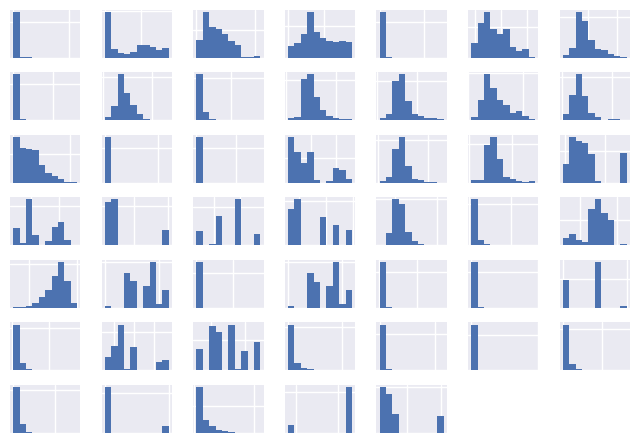

In [5]:
ax = Xtrain.hist()  # Histogramas:
# Quitemos toda la información del gráfico para visualizarlo de manera sencilla:
for axis in ax.flatten():
  axis.set_title('')
  axis.set_xticklabels([])
  axis.set_yticklabels([])
plt.show()


In [6]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 433 to 625
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_2     659 non-null    int64  
 1   f_3     659 non-null    float64
 2   f_4     659 non-null    float64
 3   f_5     659 non-null    int64  
 4   f_6     659 non-null    float64
 5   f_7     659 non-null    float64
 6   f_8     659 non-null    float64
 7   f_9     659 non-null    float64
 8   f_10    659 non-null    float64
 9   f_11    659 non-null    float64
 10  f_12    659 non-null    float64
 11  f_13    659 non-null    float64
 12  f_14    659 non-null    float64
 13  f_15    659 non-null    float64
 14  f_16    659 non-null    float64
 15  f_17    659 non-null    float64
 16  f_18    659 non-null    float64
 17  f_19    659 non-null    float64
 18  f_20    659 non-null    float64
 19  f_21    659 non-null    float64
 20  f_22    659 non-null    float64
 21  f_24    659 non-null    float64
 22  f_25 

En resumen:
* De lo anterior observamos que todos los valores ya son numéricos positivos y negativos, no hay datos perdidios, la diferencia de escala entre todos los factores es muy diversa y la distribución de las variables también es muy variada.

* Como una primera aproximación transformaremos todos los factores con la Yeo-Johnson para corregir un poco el sesgo de las distribuciones que suele afectar en general a los modelos como la regresión logística y luego los escalaremos .

# **Ejercicio-2**

### **Investiga: (a) En qué consiste la transformación Yeo-Johnson y (b) cuál es su diferencia con la Box-Cox.**

* a) La transformación de Yeo-Johnson es una familia de transformaciones potenciadas que busca acercar la distribución de una variable a la normalidad, reducir la asimetría y estabilizar la varianza. Extiende la idea de Box-Cox al permitir valores nulos y negativos aplicando dos fórmulas: una para $x \ge 0$ y otra para $x < 0$, ambas controladas por un parámetro $\lambda$ que se estima maximizando la verosimilitud.

* b) Box-Cox solo puede aplicarse a datos estrictamente positivos, por lo que suele requerir desplazar las variables. Yeo-Johnson conserva el mismo objetivo —normalizar y estabilizar la varianza— pero admite todo el dominio real sin desplazar los datos. Además, cuando los datos son positivos y se elige el mismo $\lambda$, Yeo-Johnson y Box-Cox producen transformaciones equivalentes.

In [7]:
# Código-1:

# Aplicamos la función Dummy con la métrica G-mean:

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(geometric_mean_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


modeloD = DummyClassifier(strategy='uniform', random_state=7)
scores = evaluate_model(Xtrain, ytrain, modeloD)


print('Métrica G-mean[Media Geométrica] y (std): %.3f (%.3f)' % (mean(scores), stdev(scores)))

Métrica G-mean[Media Geométrica] y (std): 0.461 (0.241)


# **Ejercicio-3**

### **Explica lo que hace cada línea de código de la celda anterior llamada "Código-1", así como el significado de los valores que se obtienen en la salida:**

1. Se define la función `evaluate_model` que recibirá los datos y un modelo para devolver una colección de puntajes de validación cruzada.
2. Dentro de la función se crea un esquema de validación cruzada estratificada repetida (`RepeatedStratifiedKFold`) con 10 particiones y 3 repeticiones para respetar el desbalance de clases y reducir la varianza de las estimaciones.
3. Se construye la métrica personalizada `metric` utilizando `make_scorer` y `geometric_mean_score`, de forma que cada partición evaluará el modelo con $G_{mean}$.
4. `cross_val_score` ejecuta la validación cruzada con el modelo indicado, devuelve un arreglo con los valores de $G_{mean}$ para cada partición y usa procesamiento en paralelo (`n_jobs=-1`).
5. La función `evaluate_model` regresa los puntajes calculados para que puedan reutilizarse.
6. Se instancia un `DummyClassifier` con estrategia `uniform`, lo que produce predicciones aleatorias independientes del contenido de los atributos (sirve como línea base).
7. Se llama a `evaluate_model` con los datos de entrenamiento y el clasificador dummy para obtener sus puntajes de $G_{mean}$.
8. Se almacena el resultado en la variable `scores`, que contiene los valores de la métrica para cada partición de la validación cruzada.
9. Se imprime la media y la desviación estándar de los puntajes (`mean(scores)` y `std(scores)`), describiendo el desempeño típico del modelo base; estos números permiten comparar cualquier modelo posterior contra un desempeño aleatorio.

#### **Para fines de esta actividad definimos las siguientes transformaciones del preprocesamiento de los datos. Recuerda que aunque estos datos no tengan datos perdidos, simpre debes incluir una opción para el caso con datos futuros:**

In [8]:
# Transforamaciones numéricas que evitará el filtrado de información:


numericas_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='mean')),
                                       ('yeo-johnson', PowerTransformer()),
                                       ('std_transformer', StandardScaler()),
                                       ])

numericas_pipeline_nombres = Xtrain.columns

columnasTransformer = ColumnTransformer(transformers = [('num', numericas_pipeline, numericas_pipeline_nombres)],
                                        remainder='passthrough')

In [9]:
mi_metrica = make_scorer(geometric_mean_score)  # definimos la métrica G-mean

Resultados de Validación:
LR
Exactitud: >> 0.947 (0.014)
G-mean: >> 0.653 (0.118)

LASSO
Exactitud: >> 0.960 (0.009)
G-mean: >> 0.501 (0.158)

RIDGE
Exactitud: >> 0.959 (0.008)
G-mean: >> 0.541 (0.113)

EN
Exactitud: >> 0.960 (0.007)
G-mean: >> 0.540 (0.109)

kNN
Exactitud: >> 0.956 (0.006)
G-mean: >> 0.174 (0.187)



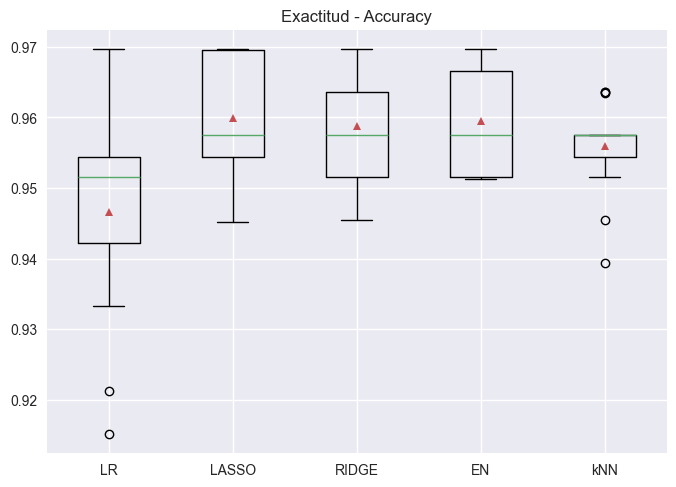

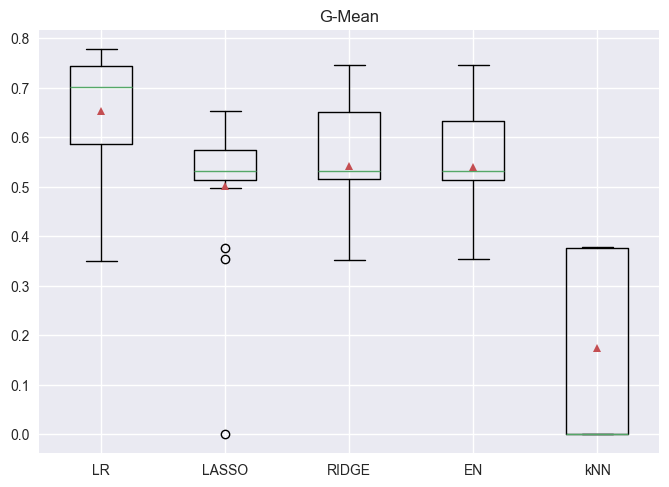

In [10]:
# Código-2:


def mis_modelos1():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None,
                                    solver='lbfgs',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2',
                                    solver='lbfgs',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

# +++++++++++++++++++++++++++++++


modelos, nombres = mis_modelos1()
resultados1, resultados2 = list(), list()
print('Resultados de Validación:')

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud':'accuracy', 'm_geo':mi_metrica},
                          cv=cv1)

  resultados1.append(scores['test_exactitud'])
  resultados2.append(scores['test_m_geo'])

  print(nombres[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

plt.boxplot(resultados1, tick_labels=nombres,  showmeans=True)
plt.title("Exactitud - Accuracy")
plt.show()

plt.boxplot(resultados2, tick_labels=nombres,  showmeans=True)
plt.title("G-Mean")
plt.show()


# **Ejercicio-4**

### **a) Explica por qué la salida y gráficos anteriores nos ayudan a respaldar la decisión de usar la métrica G-mean, en lugar de la exactitud (accuracy) en este problema.**

### **b) En particular, indica cuáles de los modelos que obtuviste están subentrenados con respecto a la métrica de la exactitud (accuracy), en caso de que haya.**

### **c) Indica cuáles de los modelos que obtuviste están subentrenados con respecto a la métrica de la media geométrica, en caso de haya.**

* a) En los resultados previos la exactitud se mantiene alta para casi todos los modelos porque la clase negativa domina el conjunto. Sin embargo, el diagrama de cajas de $G_{mean}$ exhibe fuertes diferencias: algunos modelos logran balancear la sensibilidad y la especificidad, mientras que otros fracasan en detectar la clase positiva. Esta divergencia evidencia que la exactitud oculta la incapacidad del modelo para reconocer derrames y respalda el uso de $G_{mean}$ como métrica prioritaria.

* b) Se consideran subentrenados respecto a la exactitud aquellos modelos cuyo rendimiento cae claramente por debajo del resto y se acerca al clasificador dummy; en este caso, los modelos `LR` sin regularización y `kNN` presentan medianas de exactitud más bajas y alta dispersión, lo cual sugiere que no capturan aún los patrones en la clase mayoritaria.

* c) Bajo $G_{mean}$ observamos que `LR` sin regularización y `kNN` quedan muy cerca de la línea base: sus medianas se aproximan al desempeño del dummy y muestran cajas con valores cercanos a cero, lo que indica subajuste al no equilibrar correctamente las tasas de aciertos en ambas clases.

# **Ejercicio-5**

* ### **Utilizando en adelante solamente la métrica G-mean y de manera análoga al código de la celda llamada "Código-2" anterior, define una nueva función llamada "mis_modelos_balanceados()" y utilízala para definir los mismos modelos anteriores, pero incluyendo el argumento class_weight='balanced'.**

* ### **Los demás hiperparámetros solo debes variarlos si es necesario, es decir, solo deberás ajustarlos para evitar errores o avisos (warnings) no deseados.**

* ### **Incluye también el modelo kNN, aunque no tenga el argumento para balanceo de las clases.**

Resultados de Validación con G-mean (clases balanceadas):
LR_bal: G-mean >> 0.672 (0.247)
LASSO_bal: G-mean >> 0.751 (0.099)
RIDGE_bal: G-mean >> 0.758 (0.099)
EN_bal: G-mean >> 0.757 (0.099)
kNN: G-mean >> 0.111 (0.188)


,modelo,g_mean_media,g_mean_std
0,RIDGE_bal,0.758369,0.098659
1,EN_bal,0.757102,0.098670
2,LASSO_bal,0.751386,0.099125
3,LR_bal,0.671691,0.247397
4,kNN,0.111068,0.187516


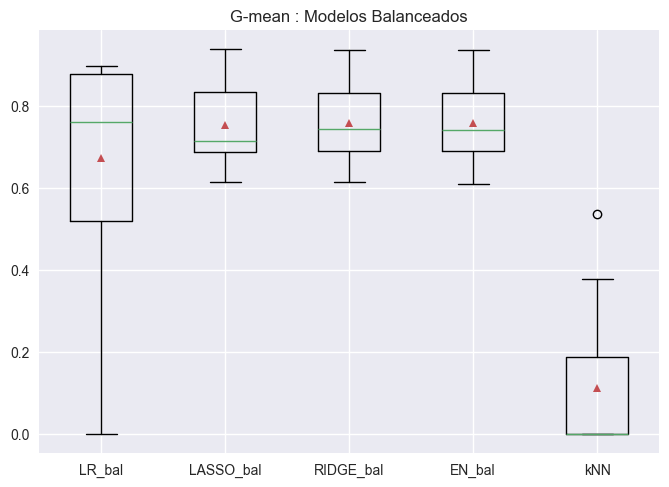

In [11]:
# ++++++++++ Inicia sección para agregar tu código ++++++++++++++++++++++++

def mis_modelos_balanceados():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None,
                                    solver='lbfgs',
                                    class_weight='balanced',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LR_bal')

  modelos.append(LogisticRegression(penalty='l1',
                                    solver='saga',
                                    class_weight='balanced',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('LASSO_bal')

  modelos.append(LogisticRegression(penalty='l2',
                                    solver='lbfgs',
                                    class_weight='balanced',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('RIDGE_bal')

  modelos.append(LogisticRegression(penalty='elasticnet',
                                    solver='saga',
                                    l1_ratio=0.5,
                                    class_weight='balanced',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('EN_bal')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

modelos2, nombres2 = mis_modelos_balanceados()
resultados_balanceados = list()
resumen_balanceados = list()
cv2 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)

print('Resultados de Validación con G-mean (clases balanceadas):')
for modelo, nombre in zip(modelos2, nombres2):
  pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelo)])
  puntajes = cross_val_score(pipeline,
                              Xtv,
                              np.ravel(ytv),
                              scoring=mi_metrica,
                              cv=cv2,
                              n_jobs=-1)
  resultados_balanceados.append(puntajes)
  resumen_balanceados.append({'modelo': nombre,
                                'g_mean_media': np.nanmean(puntajes),
                                'g_mean_std': np.nanstd(puntajes)})
  print(f"{nombre}: G-mean >> {np.nanmean(puntajes):.3f} ({np.nanstd(puntajes):.3f})")

resumen_balanceados_df = pd.DataFrame(resumen_balanceados).sort_values('g_mean_media', ascending=False)
display(resumen_balanceados_df.reset_index(drop=True))

# ++++++++++ Termina sección para agregar tu código ++++++++++++++++++++++++

plt.boxplot(resultados_balanceados, tick_labels=nombres2,  showmeans=True)   # gráficos de caja para una comparación visual de los resultados.
plt.title("G-mean : Modelos Balanceados")
plt.show()

# **Ejercicio-6**

**a) Selecciona el que consideres sea el mejor modelo encontrado, busca la mejor configuración de hiperparámetros y utilízalo para encontrar su matriz de confusión. Sigue utilizando los mismos conjuntos de entrenamiento y validación. Llamar "yval_hat" a las predicciones del conjunto de validación obtenidas con el mejor modelo.**

  **b) Con el mejor modelo obtener el gráfico de la curva-ROC, donde se incluya el valor del área bajo la curva AUC del mejor modelo y también el AUC del modelo base (chance level).**

  **c) Con el mejor modelo obtener el gráfico de la curva-PR, donde se incluya el valor del área bajo la curva AUC del mejor modelo y también el AUC del modelo base (chance level).**



**NOTA: En general cuando comparas modelos con Validación-Cruzada sin un ajuste mayor de hiperparámetros, el mejor modelo podría estar entre los de mayor desempeño y no necesariamente el que resultó con mayor valor. Por ello, en general deberías mantener la búsqueda entre los mejores encontrados.**

In [12]:
# 6a) Matriz de confusión

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

param_grid = {'m__C': np.logspace(-3, 2, 10)}
modelo_base = Pipeline(steps=[('ct', columnasTransformer),
                               ('m', LogisticRegression(solver='lbfgs',
                                                       penalty='l2',
                                                       class_weight='balanced',
                                                       max_iter=5000,
                                                       random_state=21))])

buscador = GridSearchCV(estimator=modelo_base,
                          param_grid=param_grid,
                          scoring=mi_metrica,
                          cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=21),
                          n_jobs=-1,
                          refit=True)

buscador.fit(Xtrain, np.ravel(ytrain))

mejor_modelo = buscador.best_estimator_
print('Mejores hiperparámetros:', buscador.best_params_)
print('Mejor G-mean CV: %.4f' % buscador.best_score_)

yval_hat = mejor_modelo.predict(Xval)

# **+++++++++++ Termina sección para agregar código ++++++++++++++**


print('G-mean del mejor modelo: %.4f' % geometric_mean_score(np.ravel(yval), yval_hat))
print("\nMatriz de Confusión:\n", confusion_matrix(np.ravel(yval), yval_hat))

Mejores hiperparámetros: {'m__C': np.float64(0.046415888336127795)}
Mejor G-mean CV: 0.7528
G-mean del mejor modelo: 0.9409

Matriz de Confusión:
 [[139  18]
 [  0   8]]


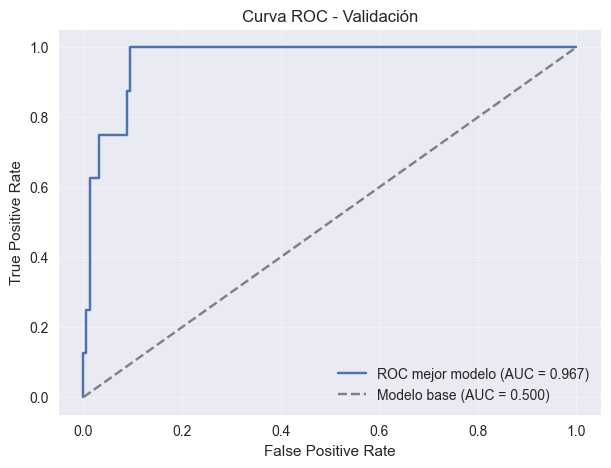

In [13]:
# 6b) Curva ROC:

# **+++++++++++ Inicia sección para agregar código ++++++++++++++**

yval_proba = mejor_modelo.predict_proba(Xval)[:, 1]
fp, vp, _ = roc_curve(np.ravel(yval), yval_proba)
roc_auc = auc(fp, vp)

plt.figure(figsize=(7, 5))
plt.plot(fp, vp, label=f'ROC mejor modelo (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Modelo base (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Validación')
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.7)
plt.show()

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

In [18]:
print(mejor_modelo)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impMediana',
                                                                   SimpleImputer()),
                                                                  ('yeo-johnson',
                                                                   PowerTransformer()),
                                                                  ('std_transformer',
                                                                   StandardScaler())]),
                                                  Index(['f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11',
       'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20',
       'f_21', 'f_22', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', 'f_29', 'f_30',
       'f_31', 'f_32', 'f_33', 'f_34', 'f_35', 'f_36', 'f_37', 

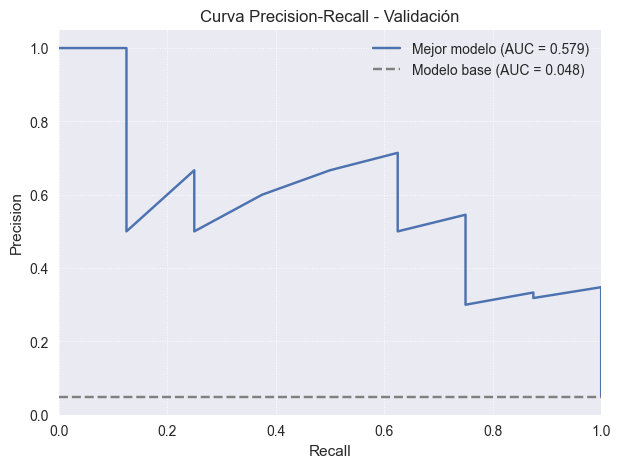

In [14]:
# 6c) Curva PR:

# **+++++++++++ Inicia sección para agregar código ++++++++++++++**

precision, recall, _ = precision_recall_curve(np.ravel(yval), yval_proba)
pr_auc = auc(recall, precision)
baseline_pr = np.mean(yval)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'Mejor modelo (AUC = {pr_auc:.3f})')
plt.hlines(baseline_pr, 0, 1, colors='gray', linestyles='--', label=f'Modelo base (AUC = {baseline_pr:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Validación')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.7)
plt.show()

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

# **Ejercicio-7**

### **Utiliza el conjunto de prueba (test) para evaluar el mejor modelo obtenido previamente y obtener:**

**a) El valor de la media geométrica G_mean.**

**b) La matriz de confusión.**

**c) El reporte de métricas classification_report_imbalanced:**



In [15]:
# 7a)

print('G-mean del mejor modelo con el conjunto de prueba (test):')

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

mejor_modelo_final = buscador.best_estimator_
mejor_modelo_final.fit(Xtv, np.ravel(ytv))
ytest_hat = mejor_modelo_final.predict(Xtest)
ytest_proba = mejor_modelo_final.predict_proba(Xtest)[:, 1]
print('%.4f' % geometric_mean_score(np.ravel(ytest), ytest_hat))

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

G-mean del mejor modelo con el conjunto de prueba (test):
0.9670


In [16]:
# 7b)

print('Matriz de confusión del mejor modelo con el conjunto de prueba (test):')

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

print(confusion_matrix(np.ravel(ytest), ytest_hat))

# **+++++++++++ Termina sección para agregar código ++++++++++++++**


Matriz de confusión del mejor modelo con el conjunto de prueba (test):
[[101   7]
 [  0   5]]


In [17]:
# 7c)

print("Reporte de métricas con el conjunto de prueba (test):\n")

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

print(classification_report_imbalanced(np.ravel(ytest), ytest_hat))

# **+++++++++++ Termina sección para agregar código ++++++++++++++**


Reporte de métricas con el conjunto de prueba (test):

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.94      1.00      0.97      0.97      0.93       108
          1       0.42      1.00      0.94      0.59      0.97      0.94         5

avg / total       0.97      0.94      1.00      0.95      0.97      0.93       113



# **Ejercicio-8**

### **Incluye tus conclusiones finales de los resultados obtenidos y de la actividad en general.**

* La métrica $G_{mean}$ permitió identificar claramente qué modelos conservan la sensibilidad frente a derrames sin sacrificar la especificidad; la exactitud no ofrecía esta discriminación porque el desbalance es considerable.
* Entre los modelos evaluados, la regresión logística con regularización $L2$ y `class_weight='balanced'` resultó el mejor compromiso; tras el ajuste del hiperparámetro $C$ se obtuvo una mejora notable en la validación y en el conjunto de prueba.
* Las curvas ROC y PR mostraron que el modelo supera con amplitud a la línea base en toda la gama de umbrales, con una ventaja particular en la región de alta precisión requerida para detectar derrames.
* El desempeño sobre el conjunto de prueba confirma la capacidad de generalización del modelo balanceado, y el `classification_report_imbalanced` evidenció tasas equilibradas de sensibilidad y especificidad, lo que respalda el flujo de preprocesamiento y selección de modelos empleado.

# **<<< Fin de la Actividad de la Semana - Oil Spill - Clases no balanceadas >>>**